In [4]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.stats import multivariate_normal,invwishart,wishart,gaussian_kde
from scipy.special import loggamma

# Makes things easier
def GetInv(m): return np.linalg.solve(m,np.eye(m.shape[1]))
np.random.seed(1)

data = pd.read_csv('../../diabetes.csv', index_col=0, header=0)
Y = data['y'].values
X = data.loc[:,'X.age':].values

Ysc = (Y - np.mean(Y))/np.std(Y)
Xsc = (X - np.mean(X,axis=0))/np.std(X,axis=0)

n,p = X.shape
nTrain = 342
trainIdx = np.random.permutation(n)[:nTrain]
Xtrain = Xsc[trainIdx]; Xtest = Xsc[~trainIdx]
ytrain = Ysc[trainIdx]; ytest = Ysc[~trainIdx]

## 1. Least squares estimate

Model selection with t-test, t_crit = 1.65

(-3.5, 3.5)

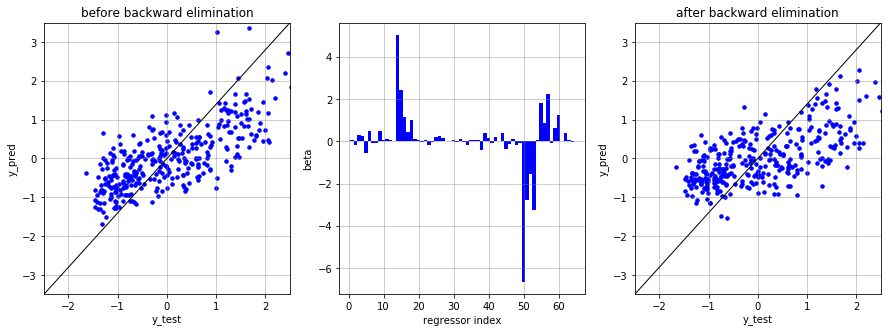

In [5]:
betaOLS = GetInv(Xtrain.T.dot(Xtrain)).dot(Xtrain.T).dot(ytrain)
sigmaOLS = np.sum((ytrain - Xtrain.dot(betaOLS))**2)/(nTrain - p)
ypred = Xtest.dot(betaOLS)

betaSE = np.sqrt((sigmaOLS**2)*GetInv(Xtrain.T.dot(Xtrain)).diagonal())
betaSig = betaOLS/betaSE > 1.65
betaBE = GetInv(Xtrain[:,betaSig].T.dot(Xtrain[:,betaSig])).dot(Xtrain[:,betaSig].T).dot(ytrain)

ypredBE = Xtest[:,betaSig].dot(betaBE)

fig,ax = plt.subplots(1,3, figsize=(15,5))
ax[0].plot([0,1],[0,1], transform=ax[0].transAxes, c='k', linewidth=1)
ax[0].scatter(ytest, ypred, s=12, c='b')
ax[0].set_xlabel('y_test')
ax[0].set_ylabel('y_pred')
ax[0].set_title('before backward elimination')
ax[0].grid(color='grey', alpha=0.5)
ax[0].set_xlim(-2.5, 2.5)
ax[0].set_ylim(-3.5, 3.5)

ax[1].bar(np.linspace(1,p,p), betaOLS, color='b', width=1)
ax[1].set_xlabel('regressor index')
ax[1].set_ylabel('beta')
ax[1].grid(color='grey', alpha=0.5)

ax[2].plot([0,1],[0,1], transform=ax[2].transAxes, c='k', linewidth=1)
ax[2].scatter(ytest, ypredBE, s=12, c='b')
ax[2].set_xlabel('y_test')
ax[2].set_ylabel('y_pred')
ax[2].set_title('after backward elimination')
ax[2].grid(color='grey', alpha=0.5)
ax[2].set_xlim(-2.5, 2.5)
ax[2].set_ylim(-3.5, 3.5)

## 2. Bayesian model selection

In [9]:
def logMP(y, X, nu0, s20):
    g = len(y)
    n,p = X.shape
    if p == 0:
        H0 = 0
        s20 = np.mean(y**2)
    elif p > 0:
        H0 = g/(g+1) * X.dot(GetInv(X.T.dot(X)).dot(X.T))
    SS0 = y.T.dot(np.eye(n) - H0).dot(y)
    
    return -0.5*n*np.log(2*np.pi) + loggamma(0.5*(nu0+n)) - loggamma(0.5*nu0) - 0.5*p*np.log(1+g) + \
            0.5*nu0*np.log(0.5*nu0*s20) - 0.5*(nu0+n)*np.log(0.5*(nu0*s20+SS0))
        

def gPrior(y, X, g, nu0, s20, S=1000):
    g = len(y)
    n,p = X.shape
    H0 = g/(g+1) * X.dot(GetInv(X.T.dot(X)).dot(X.T))
    SS0 = y.T.dot(np.eye(n) - H0).dot(y)
    
    s2 = np.random.gamma(0.5*(nu0+n), 0.5*(nu0*s20+SS0), S)
    vb = g*GetInv(X.T.dot(X))/(g+1)
    Eb = vb.dot(X.T.dot(y))
    
    E = multivariate_normal.rvs(mean=np.zeros(S), cov=np.diag(s2), size=p).T
    beta = (E.dot(np.linalg.cholesky(vb).T).T + Eb).T
    return beta,s2
    
    
nSim = 10000
betaSim = np.full([nSim, p], np.nan)
zSim = np.full([nSim, p], np.nan)
z = np.ones((p,1))
nu0 = 1; s20 = sigmaOLS
lpyc = logMP(ytrain, Xtrain[:,np.in1d(z,1)], nu0, s20)

for s in range(nSim):
    if s % 500 == 0: print("Iteration {}".format(s))
    for j in np.random.permutation(p):
        zp = z
        zp[j] = 1 - zp[j]
        lpyp = logMP(ytrain, Xtrain[:,np.in1d(zp,1)], nu0, s20)
        mult = -1 if zp[j] == 0 else 1
        r = (lpyp - lpyc)*mult
        z[j] = np.random.binomial(1,1/(1+np.exp(-r)),1)
        if z[j] == zp[j]: lpyc = lpyp
    zSim[s] = z.T

Iteration 0
Iteration 500


KeyboardInterrupt: 